<a href="https://colab.research.google.com/github/AfrizalDS/MachineLearning/blob/main/hairmate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import


In [3]:
!pip install mediapipe


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 44.4 MB/s eta 0:00:00


In [4]:
import cv2
import mediapipe as mp
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import os
import matplotlib.pyplot as plt

In [5]:
#Inisialisasi MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)


In [6]:
# Fungsi untuk menghitung jarak antar titik landmark
def calculate_distance(point1, point2):
    return ((point1.x - point2.x) ** 2 + (point1.y - point2.y) ** 2) ** 0.5


In [7]:
# Fungsi untuk ekstraksi fitur dari wajah
def extract_face_features(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image_rgb)

    if results.multi_face_landmarks:
        face_landmarks = results.multi_face_landmarks[0].landmark
        jaw_width = calculate_distance(face_landmarks[0], face_landmarks[16])
        cheekbone_width = calculate_distance(face_landmarks[1], face_landmarks[15])
        face_height = calculate_distance(face_landmarks[152], face_landmarks[10])
        forehead_width = calculate_distance(face_landmarks[9], face_landmarks[234])

        return [jaw_width, cheekbone_width, face_height, forehead_width]
    else:
        return None

In [8]:
# Fungsi augmentasi sederhana untuk data gambar
def augment_image(image):
    # Augmentasi: Flip Horizontal
    flipped_image = cv2.flip(image, 1)
    return flipped_image

# Membuat dataset fitur dari gambar wajah
dataset = []
labels = []  # Label bentuk wajah

In [9]:
# Folder dataset: subfolder per bentuk wajah (Oval, Round, dll.)
dataset_path = '/content/drive/MyDrive/face/face shape detector'
for label in os.listdir(dataset_path):
    for image_file in os.listdir(os.path.join(dataset_path, label)):
        image_path = os.path.join(dataset_path, label, image_file)
        features = extract_face_features(image_path)

        if features is not None:
            dataset.append(features)
            labels.append(label)

            # Augmentasi data
            image = cv2.imread(image_path)
            augmented_image = augment_image(image)
            augmented_path = "temp_augmented.jpg"
            cv2.imwrite(augmented_path, augmented_image)

            augmented_features = extract_face_features(augmented_path)
            if augmented_features is not None:
                dataset.append(augmented_features)
                labels.append(label)


In [10]:
#Konversi dataset ke DataFrame
df = pd.DataFrame(dataset, columns=['Jaw Width', 'Cheekbone Width', 'Face Height', 'Forehead Width'])
df['Label'] = labels

# Pisahkan data menjadi fitur dan label
X = df[['Jaw Width', 'Cheekbone Width', 'Face Height', 'Forehead Width']]
y = df['Label']

# Bagi dataset menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
# Latih model KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Evaluasi model
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Akurasi Model KNN: {accuracy * 100:.2f}%')


Akurasi Model KNN: 25.00%


In [12]:
# Fungsi untuk merekomendasikan gaya rambut berdasarkan bentuk wajah
def get_hairstyle_recommendation(face_shape):
    recommendations = {
        "oval": {
            "styles": ["Layer panjang", "Bob", "Poni depan"]

        },
        "round": {
            "styles": ["Undercut", "Poni samping", "Layer panjang"],

        },
        "square": {
            "styles": ["Layer bergelombang", "Poni tipis", "Rambut panjang"],

        },
        "heart": {
            "styles": ["Layer panjang", "Poni samping", "Bob panjang"],

        }
    }
    return recommendations.get(face_shape, {"styles": ["Gaya rambut tidak tersedia"], "images": [""]})


In [17]:
# Fungsi untuk memprediksi bentuk wajah berdasarkan gambar
def predict_face_shape(image_path):
    # Ekstraksi fitur wajah dari gambar
    features = extract_face_features(image_path)

    if features is not None:
        # Menampilkan fitur yang diekstraksi untuk debugging
        print(f"Fitur Wajah: {features}")

        # Prediksi bentuk wajah menggunakan model KNN
        face_shape = knn.predict([features])

        # Menampilkan hasil prediksi untuk debugging
        print(f"Prediksi Bentuk Wajah: {face_shape[0]}")

        return face_shape[0]
    else:
        return "Wajah tidak terdeteksi"


# Prediksi bentuk wajah dan rekomendasi gaya rambut
def predict_face_shape_with_hairstyle(image_path):
    face_shape = predict_face_shape(image_path)  # Fungsi prediksi dari kode sebelumnya
    if face_shape != "Wajah tidak terdeteksi":
        hairstyle_recommendation = get_hairstyle_recommendation(face_shape)
        print(f"Bentuk Wajah Prediksi: {face_shape}")
        print(f"Rekomendasi Gaya Rambut: {', '.join(hairstyle_recommendation['styles'])}")

        # Tampilkan gambar-gambar gaya rambut
        for img_path in hairstyle_recommendation['images']:
            if os.path.exists(img_path):
                img = cv2.imread(img_path)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                plt.imshow(img_rgb)
                plt.axis('off')  # Menyembunyikan axis
                plt.show()
            else:
                print(f"File gambar tidak ditemukan: {img_path}")
    else:
        print("Gagal mendeteksi wajah")

# Tes dengan gambar baru
new_image_path = "/content/aa.png"  # Ganti dengan jalur gambar baru
predict_face_shape_with_hairstyle(new_image_path)


Fitur Wajah: [0.07983378252273118, 0.13828403023109004, 0.5567394753535189, 0.2959430970499512]
Prediksi Bentuk Wajah: triangle
Bentuk Wajah Prediksi: triangle
Rekomendasi Gaya Rambut: Gaya rambut tidak tersedia
File gambar tidak ditemukan: 


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


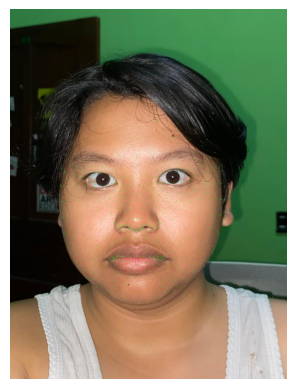

Bentuk Wajah Prediksi: Oval
Rekomendasi Gaya Rambut untuk Bentuk Wajah Oval: Pixie Cut, Bob Cut, Lob Cut, Long Waves
File gambar tidak ditemukan: oval_pixie.jpg
File gambar tidak ditemukan: oval_bob.jpg
File gambar tidak ditemukan: oval_lob.jpg
File gambar tidak ditemukan: oval_waves.jpg


In [25]:
#dengan Landmark

import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import os

# Inisialisasi MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)

# Fungsi untuk menghitung jarak antar titik landmark
def calculate_distance(point1, point2):
    return ((point1.x - point2.x) ** 2 + (point1.y - point2.y) ** 2) ** 0.5

# Fungsi untuk ekstraksi fitur dari wajah dan menampilkan landmark
def extract_face_features(image_path):
    # Baca gambar dan konversi ke RGB
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Proses gambar untuk mendeteksi wajah
    results = face_mesh.process(image_rgb)

    if results.multi_face_landmarks:
        # Ambil landmark wajah pertama (jika ada)
        face_landmarks = results.multi_face_landmarks[0].landmark

        # Menampilkan gambar dengan landmark wajah
        for landmark in face_landmarks:
            # Menghitung posisi piksel dari landmark
            x = int(landmark.x * image.shape[1])
            y = int(landmark.y * image.shape[0])

            # Gambar titik landmark pada gambar
            cv2.circle(image, (x, y), 1, (0, 255, 0), -1)  # Titik landmark (warna hijau)

        # Tampilkan gambar dengan landmark
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')  # Menyembunyikan axis
        plt.show()

        # Ekstrak beberapa fitur untuk model (misalnya lebar dagu, lebar pipi, dll.)
        jaw_width = calculate_distance(face_landmarks[0], face_landmarks[16])  # Titik 0 dan 16 adalah ujung dagu
        cheekbone_width = calculate_distance(face_landmarks[1], face_landmarks[15])  # Titik 1 dan 15 adalah tulang pipi
        face_height = calculate_distance(face_landmarks[152], face_landmarks[10])  # Titik 152 dan 10 adalah tinggi wajah
        forehead_width = calculate_distance(face_landmarks[9], face_landmarks[234])  # Titik 9 dan 234 adalah lebar dahi

        # Mengembalikan fitur yang diekstrak
        return [jaw_width, cheekbone_width, face_height, forehead_width]
    else:
        return None

# Dataset gaya rambut berdasarkan bentuk wajah
hairstyles = {
    "Oval": {
        "styles": ["Pixie Cut", "Bob Cut", "Lob Cut", "Long Waves"],
        "images": ["oval_pixie.jpg", "oval_bob.jpg", "oval_lob.jpg", "oval_waves.jpg"]
    },
    "Square": {
        "styles": ["Layered Cut", "Side-Swept Bangs", "Textured Bob", "Long Waves"],
        "images": ["square_layered.jpg", "square_side_bangs.jpg", "square_textured_bob.jpg", "square_long_waves.jpg"]
    },
    "Round": {
        "styles": ["Long Layers", "Side Part", "Shaggy Bob", "Angled Bob"],
        "images": ["round_long_layers.jpg", "round_side_part.jpg", "round_shaggy_bob.jpg", "round_angled_bob.jpg"]
    },
    "Heart": {
        "styles": ["Curtain Bangs", "Side-Parted Bob", "Long Layers", "Pixie Cut"],
        "images": ["heart_curtain_bangs.jpg", "heart_side_bob.jpg", "heart_long_layers.jpg", "heart_pixie.jpg"]
    },
    "Diamond": {
        "styles": ["Layered Bob", "Textured Lob", "Side-Parted Bangs", "Long Waves"],
        "images": ["diamond_layered_bob.jpg", "diamond_textured_lob.jpg", "diamond_side_bangs.jpg", "diamond_long_waves.jpg"]
    },
}

# Prediksi bentuk wajah (misalnya oval, square, round)
def predict_face_shape(features):
    # Asumsi: Anda sudah menambahkan logika untuk menentukan bentuk wajah berdasarkan fitur yang diekstrak
    # Di sini, kita buat logika sederhana berdasarkan lebar dagu dan pipi:
    jaw_width, cheekbone_width, face_height, forehead_width = features

    # Logika klasifikasi bentuk wajah (sederhana, bisa disesuaikan lebih lanjut)
    if jaw_width < cheekbone_width and face_height > forehead_width:
        return "Oval"
    elif jaw_width > cheekbone_width and face_height < forehead_width:
        return "Square"
    elif jaw_width == cheekbone_width and face_height == forehead_width:
        return "Round"
    elif jaw_width < cheekbone_width and face_height == forehead_width:
        return "Heart"
    else:
        return "Diamond"

# Fungsi utama untuk prediksi bentuk wajah dan rekomendasi gaya rambut
def predict_face_shape_with_hairstyle(image_path):
    features = extract_face_features(image_path)  # Fungsi deteksi wajah dan ekstraksi fitur

    if features:
        face_shape = predict_face_shape(features)  # Prediksi bentuk wajah
        print(f"Bentuk Wajah Prediksi: {face_shape}")

        # Rekomendasi gaya rambut berdasarkan bentuk wajah
        hairstyle_recommendation = hairstyles.get(face_shape, {})

        if hairstyle_recommendation:
            print(f"Rekomendasi Gaya Rambut untuk Bentuk Wajah {face_shape}: {', '.join(hairstyle_recommendation['styles'])}")

            # Tampilkan gambar-gambar gaya rambut
            for img_path in hairstyle_recommendation["images"]:
                if os.path.exists(img_path):
                    img = cv2.imread(img_path)
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    plt.imshow(img_rgb)
                    plt.axis('off')  # Menyembunyikan axis
                    plt.show()
                else:
                    print(f"File gambar tidak ditemukan: {img_path}")
        else:
            print("Tidak ada rekomendasi gaya rambut untuk bentuk wajah ini.")
    else:
        print("Wajah tidak terdeteksi")

# Tes dengan gambar baru
new_image_path = "/content/WhatsApp Image 2024-11-15 at 18.31.59_21a037d1.jpg"  # Ganti dengan jalur gambar baru
predict_face_shape_with_hairstyle(new_image_path)


In [24]:
#dengan SVM

import cv2
import mediapipe as mp
import pandas as pd
import numpy as np
from sklearn.svm import SVC  # Import SVM (Support Vector Classifier)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler  # Normalisasi Fitur
import os

# Inisialisasi MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)

# Fungsi untuk menghitung jarak antar titik landmark
def calculate_distance(point1, point2):
    return ((point1.x - point2.x) ** 2 + (point1.y - point2.y) ** 2) ** 0.5

# Fungsi untuk ekstraksi fitur dari wajah
def extract_face_features(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image_rgb)

    if results.multi_face_landmarks:
        face_landmarks = results.multi_face_landmarks[0].landmark
        jaw_width = calculate_distance(face_landmarks[0], face_landmarks[16])
        cheekbone_width = calculate_distance(face_landmarks[1], face_landmarks[15])
        face_height = calculate_distance(face_landmarks[152], face_landmarks[10])
        forehead_width = calculate_distance(face_landmarks[9], face_landmarks[234])

        return [jaw_width, cheekbone_width, face_height, forehead_width]
    else:
        return None

# Fungsi augmentasi sederhana untuk data gambar
def augment_image(image):
    # Augmentasi: Flip Horizontal
    flipped_image = cv2.flip(image, 1)
    return flipped_image

# Membuat dataset fitur dari gambar wajah
dataset = []
labels = []  # Label bentuk wajah

# Folder dataset: subfolder per bentuk wajah (Oval, Round, dll.)
dataset_path = '/content/drive/MyDrive/face/face shape detector'
for label in os.listdir(dataset_path):
    for image_file in os.listdir(os.path.join(dataset_path, label)):
        image_path = os.path.join(dataset_path, label, image_file)
        features = extract_face_features(image_path)

        if features is not None:
            dataset.append(features)
            labels.append(label)

            # Augmentasi data
            image = cv2.imread(image_path)
            augmented_image = augment_image(image)
            augmented_path = "temp_augmented.jpg"
            cv2.imwrite(augmented_path, augmented_image)

            augmented_features = extract_face_features(augmented_path)
            if augmented_features is not None:
                dataset.append(augmented_features)
                labels.append(label)

# Konversi dataset ke DataFrame
df = pd.DataFrame(dataset, columns=['Jaw Width', 'Cheekbone Width', 'Face Height', 'Forehead Width'])
df['Label'] = labels

# Pisahkan data menjadi fitur dan label
X = df[['Jaw Width', 'Cheekbone Width', 'Face Height', 'Forehead Width']]
y = df['Label']

# Bagi dataset menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisasi fitur untuk SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Latih model SVM
svm = SVC(kernel='linear')  # Bisa menggunakan 'linear', 'rbf', dll. untuk kernel yang berbeda
svm.fit(X_train_scaled, y_train)

# Evaluasi model
y_pred = svm.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Akurasi Model SVM: {accuracy * 100:.2f}%')

# Tampilkan metrik evaluasi lainnya
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Fungsi untuk merekomendasikan gaya rambut berdasarkan bentuk wajah
def get_hairstyle_recommendation(face_shape):
    recommendations = {
        "Oval": ["Layer panjang", "Bob", "Poni depan"],
        "Round": ["Undercut", "Poni samping", "Layer panjang"],
        "Square": ["Layer bergelombang", "Poni tipis", "Rambut panjang"],
        "Heart": ["Layer panjang", "Poni samping", "Bob panjang"]
        # Tambahkan gaya rambut untuk bentuk wajah lain sesuai kebutuhan
    }
    return recommendations.get(face_shape, ["Gaya rambut tidak tersedia untuk bentuk wajah ini"])

# Prediksi bentuk wajah dan rekomendasi gaya rambut
def predict_face_shape_with_hairstyle(image_path):
    features = extract_face_features(image_path)
    if features is not None:
        features_scaled = scaler.transform([features])  # Normalisasi fitur
        face_shape = svm.predict(features_scaled)[0]
        hairstyle_recommendation = get_hairstyle_recommendation(face_shape)
        print(f"Bentuk Wajah Prediksi: {face_shape}")
        print(f"Rekomendasi Gaya Rambut: {', '.join(hairstyle_recommendation)}")
    else:
        print("Gagal mendeteksi wajah")

# Tes dengan gambar baru
new_image_path = "/content/WhatsApp Image 2024-11-15 at 18.31.59_21a037d1.jpg"  # Ganti dengan jalur gambar baru
predict_face_shape_with_hairstyle(new_image_path)


Akurasi Model SVM: 17.50%

Classification Report:
              precision    recall  f1-score   support

     diamond       0.00      0.00      0.00         5
       heart       0.17      0.25      0.20         4
      oblong       0.10      0.17      0.12         6
        oval       0.00      0.00      0.00         9
       round       0.60      0.43      0.50         7
      square       0.00      0.00      0.00         6
    triangle       0.29      0.67      0.40         3

    accuracy                           0.17        40
   macro avg       0.16      0.22      0.18        40
weighted avg       0.16      0.17      0.16        40


Confusion Matrix:
[[0 1 1 0 0 2 1]
 [0 1 1 0 1 0 1]
 [0 0 1 0 0 3 2]
 [0 2 4 0 1 2 0]
 [0 1 0 0 3 3 0]
 [1 1 3 0 0 0 1]
 [0 0 0 0 0 1 2]]
Bentuk Wajah Prediksi: oblong
Rekomendasi Gaya Rambut: Gaya rambut tidak tersedia untuk bentuk wajah ini


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/b